# Task 1



In [6]:
import os
import json
import urllib.request
import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet34
from torchvision import transforms, datasets

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# Transforms
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset path
dataset_path = "/content/TestDataSet/TestDataSet"

# Load PyTorch's official class index mapping from GitHub
class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

# Create synset ID to index mapping (wnid -> class index)
synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}  # Format: {'n01440764': 0, ...}

# Map folder names (synsets) to class indices
folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

# DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Evaluation
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, pred_top1 = outputs.topk(1, dim=1)
        _, pred_top5 = outputs.topk(5, dim=1)

        top1_correct += (pred_top1.squeeze() == labels).sum().item()
        top5_correct += sum([labels[i].item() in pred_top5[i].tolist() for i in range(len(labels))])
        total += labels.size(0)

# Accuracy
top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2

Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 18.99it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating adversarial examples with FGSM (ε = 0.02)...


Generating adversarial examples: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]


Maximum L∞ distance: 0.020000100135803223
Evaluating original model on adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 34.50it/s]


Adversarial Top-1 Accuracy: 6.00%
Adversarial Top-5 Accuracy: 35.40%
Top-1 Accuracy Drop: 70.00%
Top-5 Accuracy Drop: 58.80%
Saving adversarial dataset...
Visualizing successful adversarial examples...


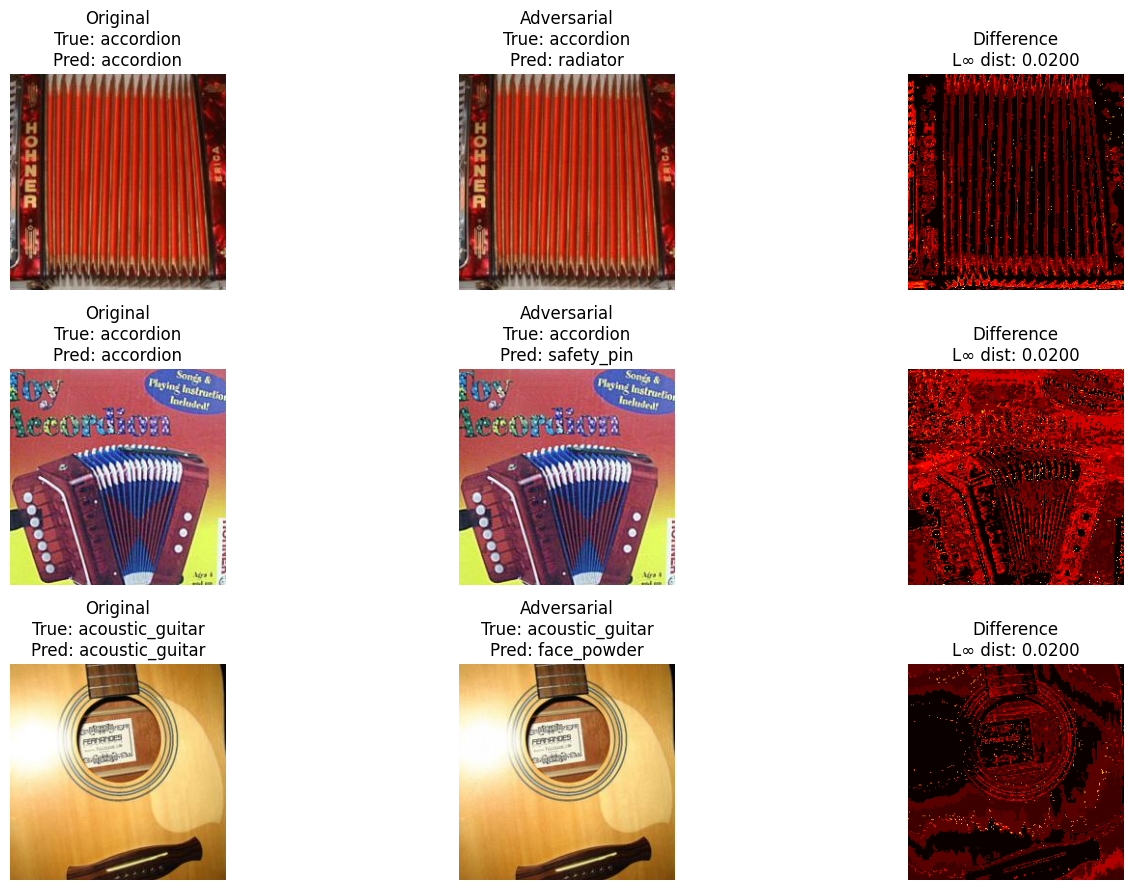

Done! Adversarial Test Set 1 has been created and model performance has been evaluated.


In [7]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained ResNet-34 model
model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()  # Set to evaluation mode

# Define normalization parameters
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset path - adjust this to match your environment
dataset_path = "/content/TestDataSet/TestDataSet"  # Use the path from your code

# Load PyTorch's official class index mapping from GitHub
class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

# Create synset ID to index mapping (wnid -> class index)
synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}  # Format: {'n01440764': 0, ...}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}  # For human-readable labels

# Map folder names (synsets) to class indices
folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

# DataLoader - using a smaller batch size for adversarial examples generation
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Function to denormalize images for visualization
def denormalize(tensor):
    """Convert normalized image tensor to numpy array for visualization"""
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

# Function to evaluate model performance
def evaluate_model(model, dataloader, top_k=(1, 5)):
    """Evaluate model performance on given dataloader"""
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate top-k accuracy for all specified k values
            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                # Check if the correct label is in the top-k predictions
                top_k_preds = predictions[:, :k]

                # Count correct predictions (matching any of the top-k)
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    # Calculate accuracy
    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

# Evaluate original model on clean dataset
print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

# FGSM Attack function
def fgsm_attack(model, images, labels, epsilon=0.02):
    """
    Generate adversarial examples using Fast Gradient Sign Method (FGSM)

    Args:
        model: neural network model
        images: input images
        labels: true labels
        epsilon: attack budget

    Returns:
        perturbed_images: adversarial examples
    """
    # Create a copy of the input and set requires_grad to True
    perturbed_images = images.clone().detach().requires_grad_(True)

    # Forward pass
    outputs = model(perturbed_images)

    # Calculate loss
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Zero gradients
    model.zero_grad()

    # Backward pass to calculate gradients
    loss.backward()

    # Create FGSM perturbation: ε * sign(∇x L)
    with torch.no_grad():
        perturbation = epsilon * torch.sign(perturbed_images.grad.data)

        # Add perturbation to create adversarial example
        perturbed_images = perturbed_images.detach() + perturbation

        # Ensure the perturbed images have valid values within epsilon L∞ norm
        for i in range(3):  # For each channel
            min_val = images[:, i].min() - epsilon
            max_val = images[:, i].max() + epsilon
            perturbed_images[:, i] = torch.clamp(perturbed_images[:, i], min=min_val, max=max_val)

    return perturbed_images

# Create a custom dataset class for adversarial examples
class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return adversarial image with original label
        return self.adv_images[idx], self.labels[idx]

# Generate adversarial examples with FGSM
def generate_adversarial_dataset(model, dataloader, epsilon=0.02):
    """Generate adversarial examples for the entire dataset"""
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    l_inf_distances = []

    for images, labels in tqdm(dataloader, desc="Generating adversarial examples"):
        images, labels = images.to(device), labels.to(device)

        # Get original predictions
        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)

        # Generate adversarial examples
        adv_imgs = fgsm_attack(model, images, labels, epsilon)

        # Get adversarial predictions
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)

        # Calculate L∞ distance
        l_inf_dist = (adv_imgs - images).abs().max(dim=1)[0].max(dim=1)[0].max(dim=1)[0]

        # Store everything
        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        l_inf_distances.append(l_inf_dist.cpu())

    # Concatenate all batches
    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)
    l_inf_distances = torch.cat(l_inf_distances)

    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'l_inf_distances': l_inf_distances
    }

# Generate adversarial examples
print("Generating adversarial examples with FGSM (ε = 0.02)...")
adv_data = generate_adversarial_dataset(model, dataloader, epsilon=0.02)

# Verify L∞ distance with a small tolerance for floating-point precision
max_l_inf = adv_data['l_inf_distances'].max().item()
print(f"Maximum L∞ distance: {max_l_inf}")
tolerance = 1e-6  # Add small tolerance for floating-point precision
assert max_l_inf <= 0.02 + tolerance, f"L∞ distance exceeds budget significantly: {max_l_inf} > 0.02"

# Create an adversarial dataset
adv_dataset = AdversarialDataset(adv_data['adv_images'], adv_data['original_labels'])
adv_dataloader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

# Evaluate model on adversarial dataset
print("Evaluating original model on adversarial dataset...")
adv_accuracy = evaluate_model(model, adv_dataloader)
print(f"Adversarial Top-1 Accuracy: {adv_accuracy[1]:.2f}%")
print(f"Adversarial Top-5 Accuracy: {adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - adv_accuracy[5]:.2f}%")

# Save adversarial dataset
print("Saving adversarial dataset...")
adv_dataset_path = "/content/AdversarialTestSet1"
os.makedirs(adv_dataset_path, exist_ok=True)

# Get class folders from original dataset
class_folders = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Create same folder structure for adversarial dataset
for folder in class_folders:
    os.makedirs(os.path.join(adv_dataset_path, folder), exist_ok=True)

# Function to save images
def save_tensor_as_image(tensor, path):
    # Denormalize the tensor
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

# Iterate through dataset to save adversarial images with original folder structure
counter = 0
for idx, (img_path, label) in enumerate(dataset.samples):
    # Get class folder name
    class_folder = os.path.basename(os.path.dirname(img_path))
    img_name = os.path.basename(img_path)

    # Save adversarial image
    save_path = os.path.join(adv_dataset_path, class_folder, img_name)
    save_tensor_as_image(adv_data['adv_images'][counter], save_path)
    counter += 1

# Visualize examples where the attack was successful
def visualize_adversarial_examples(orig_imgs, adv_imgs, orig_labels,
                                  clean_preds, adv_preds, class_dict, num_examples=3):
    """Visualize successful adversarial examples"""
    # Find indices where clean prediction was correct but adversarial prediction was wrong
    successful_idx = []

    for i in range(len(orig_labels)):
        if clean_preds[i].item() == orig_labels[i].item() and adv_preds[i].item() != orig_labels[i].item():
            successful_idx.append(i)

            # Stop once we have enough examples
            if len(successful_idx) >= num_examples:
                break

    if len(successful_idx) == 0:
        print("No successful attacks found!")
        return

    plt.figure(figsize=(15, 3*len(successful_idx)))

    for i, idx in enumerate(successful_idx):
        # Original image
        plt.subplot(len(successful_idx), 3, i*3 + 1)
        plt.imshow(denormalize(orig_imgs[idx]))
        true_label = class_dict.get(orig_labels[idx].item(), f"Class {orig_labels[idx].item()}")
        pred_label = class_dict.get(clean_preds[idx].item(), f"Class {clean_preds[idx].item()}")
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(len(successful_idx), 3, i*3 + 2)
        plt.imshow(denormalize(adv_imgs[idx]))
        adv_pred_label = class_dict.get(adv_preds[idx].item(), f"Class {adv_preds[idx].item()}")
        plt.title(f"Adversarial\nTrue: {true_label}\nPred: {adv_pred_label}")
        plt.axis('off')

        # Difference (magnified)
        plt.subplot(len(successful_idx), 3, i*3 + 3)
        diff = (adv_imgs[idx] - orig_imgs[idx]).abs().mean(dim=0)
        # Normalize the difference for better visualization
        diff = diff / diff.max() if diff.max() > 0 else diff
        plt.imshow(diff.cpu().numpy(), cmap='hot')
        plt.title(f"Difference\nL∞ dist: {(adv_imgs[idx] - orig_imgs[idx]).abs().max().item():.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("/content/adversarial_examples.png")
    plt.show()

# Visualize successful attacks
print("Visualizing successful adversarial examples...")
visualize_adversarial_examples(
    adv_data['original_images'],
    adv_data['adv_images'],
    adv_data['original_labels'],
    adv_data['predicted_clean_labels'],
    adv_data['predicted_adv_labels'],
    idx_to_label
)

print("Done! Adversarial Test Set 1 has been created and model performance has been evaluated.")

# Task 3

Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 17.77it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating improved adversarial examples (targeted PGD attack with momentum)...


Generating improved adversarial examples: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


Maximum L∞ distance: 0.020000100135803223
Evaluating original model on improved adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 32.98it/s]


Improved Adversarial Top-1 Accuracy: 3.00%
Improved Adversarial Top-5 Accuracy: 10.60%
Top-1 Accuracy Drop: 73.00%
Top-5 Accuracy Drop: 83.60%
Relative Top-1 Accuracy Drop: 96.05%
Relative Top-5 Accuracy Drop: 88.75%
Saving improved adversarial dataset...
Visualizing successful adversarial examples...


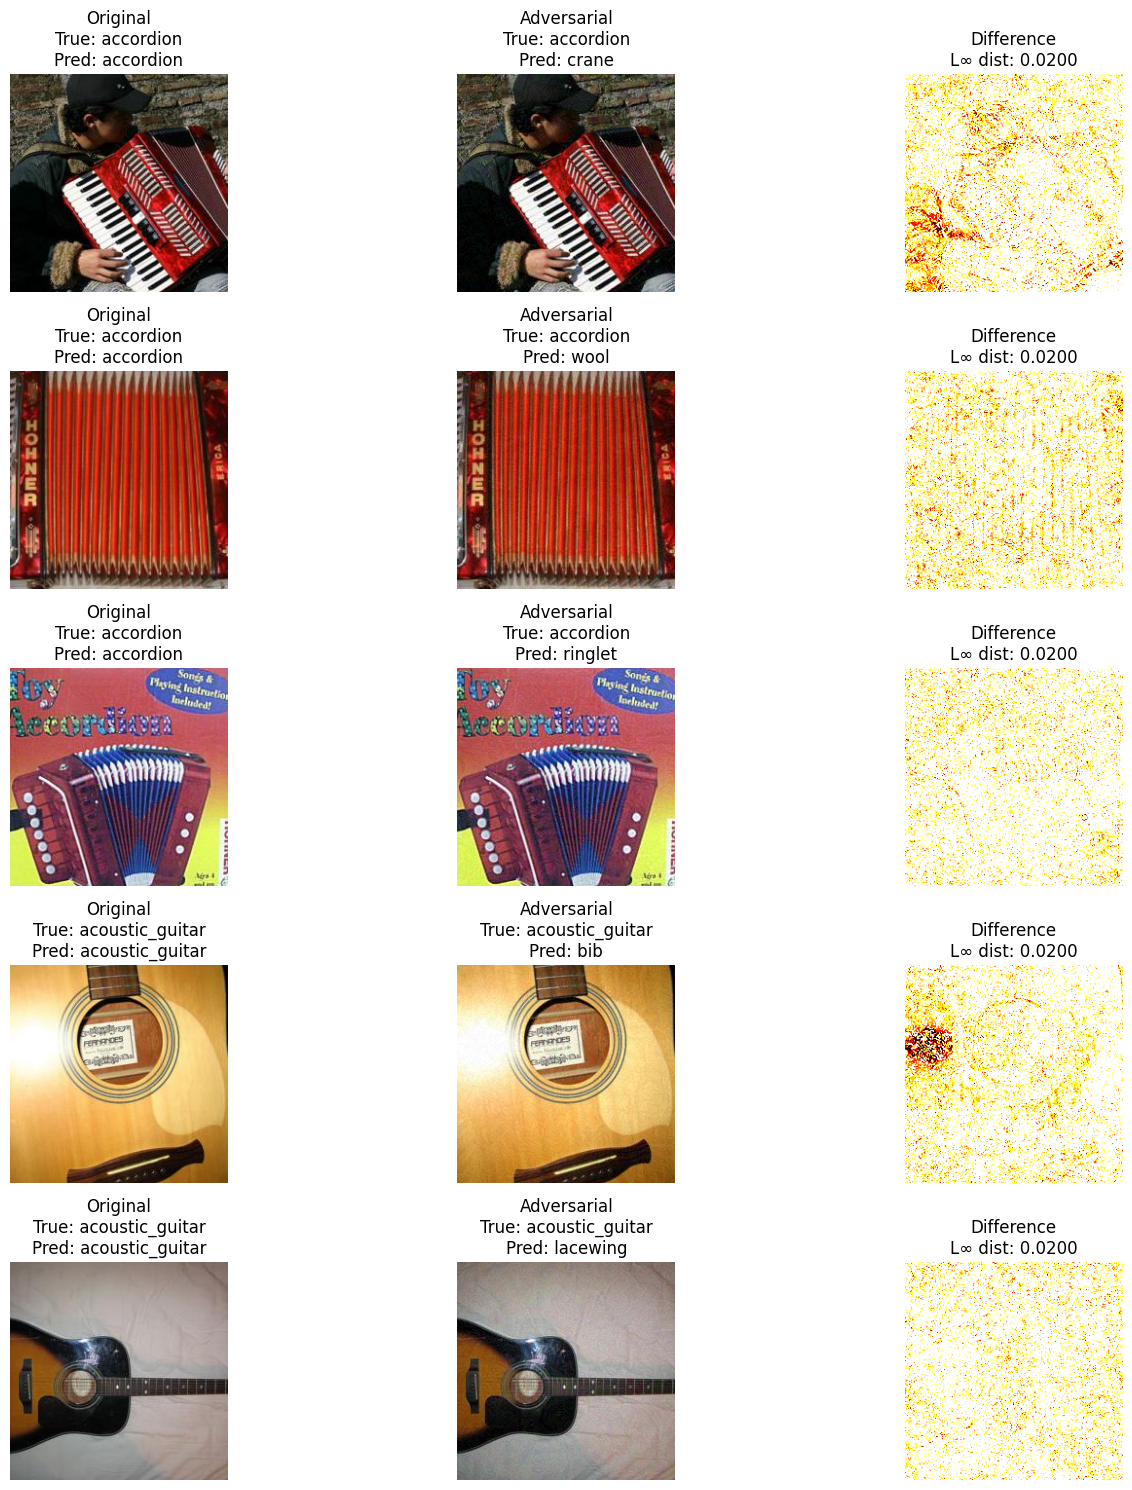

Done! Adversarial Test Set 2 has been created and model performance has been evaluated.


In [9]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained ResNet-34 model
model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()  # Set to evaluation mode

# Define normalization parameters
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset path - adjust if needed
dataset_path = "/content/TestDataSet/TestDataSet"

# Load PyTorch's official class index mapping from GitHub
class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

# Create synset ID to index mapping (wnid -> class index)
synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}  # Format: {'n01440764': 0, ...}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}  # For human-readable labels

# Map folder names (synsets) to class indices
folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

# DataLoader - using a smaller batch size for adversarial examples generation
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Function to denormalize images for visualization
def denormalize(tensor):
    """Convert normalized image tensor to numpy array for visualization"""
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

# Function to evaluate model performance
def evaluate_model(model, dataloader, top_k=(1, 5)):
    """Evaluate model performance on given dataloader"""
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate top-k accuracy for all specified k values
            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                # Check if the correct label is in the top-k predictions
                top_k_preds = predictions[:, :k]

                # Count correct predictions (matching any of the top-k)
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    # Calculate accuracy
    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

# Evaluate original model on clean dataset
print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

# Create a custom dataset class for adversarial examples
class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return adversarial image with original label
        return self.adv_images[idx], self.labels[idx]

# Function to save images
def save_tensor_as_image(tensor, path):
    # Denormalize the tensor
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

# FIX: Convert epsilon from [0,1] space to normalized space for each channel
def get_epsilon_per_channel(epsilon, std_norms):
    """Convert epsilon from [0,1] space to normalized space for each channel"""
    return [epsilon / s for s in std_norms]

# FIX: Improved attack strategy that correctly handles normalization
def improved_attack(model, images, labels, epsilon=0.02, alpha=0.005, num_steps=10):
    """
    Generates adversarial examples using PGD with targeted approach and momentum,
    properly handling normalized images.

    Args:
        model: neural network model
        images: original images (normalized)
        labels: true labels
        epsilon: maximum perturbation allowed in [0,1] space
        alpha: step size for each iteration in [0,1] space
        num_steps: number of iterations

    Returns:
        perturbed_images: adversarial examples (normalized)
    """
    # Convert epsilon to normalized space for each channel
    epsilon_per_channel = get_epsilon_per_channel(epsilon, std_norms)
    alpha_per_channel = get_epsilon_per_channel(alpha, std_norms)

    # Make a copy of the original images
    perturbed_images = images.clone().detach()

    # Store the original images for constraining perturbation
    original_images = images.clone().detach()

    # Initialize previous gradient for momentum
    prev_grad = torch.zeros_like(perturbed_images)

    # Find target classes (different from original)
    with torch.no_grad():
        outputs = model(images)
        original_probs = torch.softmax(outputs, dim=1)

        # Sort probabilities to get the most likely classes after the correct one
        sorted_probs, sorted_indices = torch.sort(original_probs, dim=1, descending=True)

        # For each image, choose a target class (low probability but not zero)
        target_indices = sorted_indices[:, torch.randint(900, 950, (images.size(0),))]

    # PGD attack with targeted approach and momentum
    for _ in range(num_steps):
        # Set requires_grad to true for the current step
        perturbed_images.requires_grad = True

        # Forward pass
        outputs = model(perturbed_images)

        # For targeted attack, we want to maximize the probability of the target class
        target_log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        gathered_logits = target_log_probs[torch.arange(images.size(0)), target_indices]

        # Loss is negative log probability of target class (we want to maximize, so minimize negative)
        loss = -gathered_logits.sum()

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Compute gradient with momentum
        momentum = 0.9  # Momentum parameter
        current_grad = perturbed_images.grad.data
        grad_with_momentum = momentum * prev_grad + current_grad / current_grad.abs().mean()
        prev_grad = grad_with_momentum.clone()

        # Update perturbed images with gradient descent (since we're minimizing negative log prob)
        with torch.no_grad():
            # Apply different step sizes for each channel
            for c in range(3):
                perturbed_images[:, c, :, :] = perturbed_images[:, c, :, :].detach() - alpha_per_channel[c] * torch.sign(grad_with_momentum[:, c, :, :])

            # Project back to epsilon ball around original images (per channel)
            for c in range(3):
                delta = perturbed_images[:, c, :, :] - original_images[:, c, :, :]
                delta = torch.clamp(delta, min=-epsilon_per_channel[c], max=epsilon_per_channel[c])
                perturbed_images[:, c, :, :] = original_images[:, c, :, :] + delta

    return perturbed_images

# FIX: Calculate L∞ distance in the original [0,1] space
def calculate_linf_distance(adv_images, orig_images):
    """Calculate L∞ distance in the original [0,1] space"""
    # First denormalize to [0,1] space (but keep as tensors)
    denorm_adv = adv_images.clone().detach()
    denorm_orig = orig_images.clone().detach()

    for c in range(3):
        denorm_adv[:, c, :, :] = denorm_adv[:, c, :, :] * std_norms[c] + mean_norms[c]
        denorm_orig[:, c, :, :] = denorm_orig[:, c, :, :] * std_norms[c] + mean_norms[c]

    # Calculate L∞ distance in [0,1] space
    l_inf_dist = (denorm_adv - denorm_orig).abs().max(dim=1)[0].max(dim=1)[0].max(dim=1)[0]
    return l_inf_dist

# Generate improved adversarial examples
def generate_improved_adversarial_dataset(model, dataloader, epsilon=0.02):
    """Generate improved adversarial examples for the entire dataset"""
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    l_inf_distances = []

    for images, labels in tqdm(dataloader, desc="Generating improved adversarial examples"):
        images, labels = images.to(device), labels.to(device)

        # Get original predictions
        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)

        # Generate adversarial examples using improved attack
        adv_imgs = improved_attack(model, images, labels, epsilon=epsilon)

        # Get adversarial predictions
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)

        # Calculate L∞ distance in [0,1] space
        l_inf_dist = calculate_linf_distance(adv_imgs, images)

        # Store everything
        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        l_inf_distances.append(l_inf_dist.cpu())

    # Concatenate all batches
    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)
    l_inf_distances = torch.cat(l_inf_distances)

    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'l_inf_distances': l_inf_distances
    }

# Generate improved adversarial examples
print("Generating improved adversarial examples (targeted PGD attack with momentum)...")
adv_data = generate_improved_adversarial_dataset(model, dataloader, epsilon=0.02)

# Verify L∞ distance with a small tolerance for floating-point precision
max_l_inf = adv_data['l_inf_distances'].max().item()
print(f"Maximum L∞ distance: {max_l_inf}")
tolerance = 1e-6  # Add small tolerance for floating-point precision
assert max_l_inf <= 0.02 + tolerance, f"L∞ distance exceeds budget significantly: {max_l_inf} > 0.02"

# Create an adversarial dataset
adv_dataset = AdversarialDataset(adv_data['adv_images'], adv_data['original_labels'])
adv_dataloader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

# Evaluate model on improved adversarial dataset
print("Evaluating original model on improved adversarial dataset...")
adv_accuracy = evaluate_model(model, adv_dataloader)
print(f"Improved Adversarial Top-1 Accuracy: {adv_accuracy[1]:.2f}%")
print(f"Improved Adversarial Top-5 Accuracy: {adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - adv_accuracy[5]:.2f}%")
print(f"Relative Top-1 Accuracy Drop: {(100 * (clean_accuracy[1] - adv_accuracy[1]) / clean_accuracy[1]):.2f}%")
print(f"Relative Top-5 Accuracy Drop: {(100 * (clean_accuracy[5] - adv_accuracy[5]) / clean_accuracy[5]):.2f}%")

# Save improved adversarial dataset
print("Saving improved adversarial dataset...")
adv_dataset_path = "/content/AdversarialTestSet2"
os.makedirs(adv_dataset_path, exist_ok=True)

# Get class folders from original dataset
class_folders = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Create same folder structure for adversarial dataset
for folder in class_folders:
    os.makedirs(os.path.join(adv_dataset_path, folder), exist_ok=True)

# Iterate through dataset to save adversarial images with original folder structure
counter = 0
for idx, (img_path, label) in enumerate(dataset.samples):
    # Get class folder name
    class_folder = os.path.basename(os.path.dirname(img_path))
    img_name = os.path.basename(img_path)

    # Save adversarial image
    save_path = os.path.join(adv_dataset_path, class_folder, img_name)
    save_tensor_as_image(adv_data['adv_images'][counter], save_path)
    counter += 1

# Visualize examples where the attack was successful
def visualize_adversarial_examples(orig_imgs, adv_imgs, orig_labels,
                                  clean_preds, adv_preds, class_dict, num_examples=5):
    """Visualize successful adversarial examples"""
    # Find indices where clean prediction was correct but adversarial prediction was wrong
    successful_idx = []

    for i in range(len(orig_labels)):
        if clean_preds[i].item() == orig_labels[i].item() and adv_preds[i].item() != orig_labels[i].item():
            successful_idx.append(i)

            # Stop once we have enough examples
            if len(successful_idx) >= num_examples:
                break

    if len(successful_idx) == 0:
        print("No successful attacks found!")
        return

    plt.figure(figsize=(15, 3*len(successful_idx)))

    for i, idx in enumerate(successful_idx):
        # Original image
        plt.subplot(len(successful_idx), 3, i*3 + 1)
        plt.imshow(denormalize(orig_imgs[idx]))
        true_label = class_dict.get(orig_labels[idx].item(), f"Class {orig_labels[idx].item()}")
        pred_label = class_dict.get(clean_preds[idx].item(), f"Class {clean_preds[idx].item()}")
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(len(successful_idx), 3, i*3 + 2)
        plt.imshow(denormalize(adv_imgs[idx]))
        adv_pred_label = class_dict.get(adv_preds[idx].item(), f"Class {adv_preds[idx].item()}")
        plt.title(f"Adversarial\nTrue: {true_label}\nPred: {adv_pred_label}")
        plt.axis('off')

        # Difference (magnified)
        plt.subplot(len(successful_idx), 3, i*3 + 3)

        # Calculate difference in [0,1] space for better visualization
        denorm_orig = denormalize(orig_imgs[idx])
        denorm_adv = denormalize(adv_imgs[idx])
        diff = np.abs(denorm_adv - denorm_orig).mean(axis=2)

        # Normalize the difference for better visualization
        diff = diff / diff.max() if diff.max() > 0 else diff
        plt.imshow(diff, cmap='hot')

        # Get L∞ distance in [0,1] space
        l_inf = calculate_linf_distance(adv_imgs[idx].unsqueeze(0), orig_imgs[idx].unsqueeze(0)).item()
        plt.title(f"Difference\nL∞ dist: {l_inf:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("/content/improved_adversarial_examples.png")
    plt.show()

# Visualize successful attacks
print("Visualizing successful adversarial examples...")
visualize_adversarial_examples(
    adv_data['original_images'],
    adv_data['adv_images'],
    adv_data['original_labels'],
    adv_data['predicted_clean_labels'],
    adv_data['predicted_adv_labels'],
    idx_to_label,
    num_examples=5
)

print("Done! Adversarial Test Set 2 has been created and model performance has been evaluated.")

# Task 4

In [10]:

import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained ResNet-34 model
model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()  # Set to evaluation mode

# Define normalization parameters
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset path - adjust if needed
dataset_path = "/content/TestDataSet/TestDataSet"

# Load PyTorch's official class index mapping from GitHub
class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

# Create synset ID to index mapping (wnid -> class index)
synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}  # Format: {'n01440764': 0, ...}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}  # For human-readable labels

# Map folder names (synsets) to class indices
folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

# DataLoader - using a smaller batch size for adversarial examples generation
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Function to denormalize images for visualization
def denormalize(tensor):
    """Convert normalized image tensor to numpy array for visualization"""
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

# Function to evaluate model performance
def evaluate_model(model, dataloader, top_k=(1, 5)):
    """Evaluate model performance on given dataloader"""
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate top-k accuracy for all specified k values
            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                # Check if the correct label is in the top-k predictions
                top_k_preds = predictions[:, :k]

                # Count correct predictions (matching any of the top-k)
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    # Calculate accuracy
    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

# Evaluate original model on clean dataset
print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

# Create a custom dataset class for adversarial examples
class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return adversarial image with original label
        return self.adv_images[idx], self.labels[idx]

# Function to save images
def save_tensor_as_image(tensor, path):
    # Denormalize the tensor
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

# Helper function to create a patch mask
def create_patch_mask(img_shape, patch_size=32, position=None):
    """
    Creates a binary mask for the patch location

    Args:
        img_shape: Shape of the image (C, H, W)
        patch_size: Size of the square patch
        position: (x, y) position for top-left corner of patch. If None, random position.

    Returns:
        Binary mask of shape (C, H, W) with 1s in the patch area
    """
    _, height, width = img_shape

    # Initialize mask with zeros
    mask = torch.zeros(img_shape, device=device)

    # If no position provided, select random position for patch
    if position is None:
        max_x = width - patch_size
        max_y = height - patch_size

        # Ensure patch stays within image
        x = torch.randint(0, max(1, max_x), (1,)).item()
        y = torch.randint(0, max(1, max_y), (1,)).item()
    else:
        x, y = position

    # Set patch area to 1
    mask[:, y:y+patch_size, x:x+patch_size] = 1.0

    return mask, (x, y)

# Targeted patch attack
def patch_attack(model, images, labels, epsilon=0.5, alpha=0.1, num_steps=20, patch_size=32):
    """
    Generate adversarial examples by only perturbing a small patch of the image
    using PGD with targeted attack approach

    Args:
        model: neural network model
        images: original images
        labels: true labels
        epsilon: maximum perturbation allowed within the patch (L∞ norm)
        alpha: step size for each iteration
        num_steps: number of iterations
        patch_size: size of the square patch

    Returns:
        perturbed_images: adversarial examples
    """
    batch_size = images.size(0)

    # Make a copy of the original images
    perturbed_images = images.clone().detach()

    # Create a patch mask for each image in the batch
    patch_masks = []
    patch_positions = []

    for i in range(batch_size):
        mask, position = create_patch_mask(images[i].shape, patch_size=patch_size)
        patch_masks.append(mask)
        patch_positions.append(position)

    patch_masks = torch.stack(patch_masks)

    # Initialize momentum accumulator
    momentum_accum = torch.zeros_like(images)

    # Find target classes (most different from original)
    with torch.no_grad():
        outputs = model(images)

        # Get prediction logits
        probs = torch.softmax(outputs, dim=1)

        # Sort probabilities to find target classes
        # We'll target the classes with lowest probability (most different)
        _, sorted_indices = torch.sort(probs, dim=1)

        # Choose target classes (using indices 20-40 to avoid classes with truly zero probability)
        target_indices = sorted_indices[:, torch.randint(20, 40, (batch_size,))]

    # PGD attack with targeted approach and momentum
    for step in range(num_steps):
        # Set requires_grad to true for the current step
        perturbed_images.requires_grad = True

        # Forward pass
        outputs = model(perturbed_images)

        # For targeted attack, maximize prob of target class
        target_log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        gathered_logits = target_log_probs[torch.arange(batch_size), target_indices]

        # Loss is negative log probability of target class (we want to maximize)
        loss = -gathered_logits.sum()

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Apply momentum
        with torch.no_grad():
            grad = perturbed_images.grad.data

            # Apply momentum (helps escape local minima)
            momentum = 0.9
            momentum_accum = momentum * momentum_accum + grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)

            # Update only the patch area with larger step size
            # Since we have a smaller area to modify, we use larger epsilon and alpha
            delta = alpha * torch.sign(momentum_accum)

            # Only apply updates to the patch area using the mask
            delta = delta * patch_masks

            # Update perturbed images
            perturbed_images = perturbed_images.detach() - delta

            # Project back to epsilon ball around original image, but only for patch
            # For areas outside patch, keep original image
            delta = perturbed_images - images
            delta = torch.clamp(delta, min=-epsilon, max=epsilon)
            delta = delta * patch_masks  # Apply mask to ensure only patch is modified

            # Combine original images with perturbed patch
            perturbed_images = images + delta

            # Ensure values are in valid range
            perturbed_images = torch.clamp(perturbed_images, min=0, max=1)

    return perturbed_images, patch_positions

# Generate patch adversarial examples
def generate_patch_adversarial_dataset(model, dataloader, epsilon=0.5, patch_size=32):
    """Generate patch adversarial examples for the entire dataset"""
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    patch_positions_list = []

    for images, labels in tqdm(dataloader, desc="Generating patch adversarial examples"):
        images, labels = images.to(device), labels.to(device)

        # Get original predictions
        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)

        # Generate adversarial examples using patch attack
        adv_imgs, patch_pos = patch_attack(
            model, images, labels,
            epsilon=epsilon,
            alpha=epsilon/5,
            num_steps=20,
            patch_size=patch_size
        )

        # Get adversarial predictions
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)

        # Store everything
        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        patch_positions_list.extend(patch_pos)

    # Concatenate all batches
    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)

    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'patch_positions': patch_positions_list
    }

# Generate patch adversarial examples with higher epsilon
print("Generating patch adversarial examples (32x32 patch, ε = 0.5)...")
patch_adv_data = generate_patch_adversarial_dataset(model, dataloader, epsilon=0.5, patch_size=32)

# Create an adversarial dataset
patch_adv_dataset = AdversarialDataset(patch_adv_data['adv_images'], patch_adv_data['original_labels'])
patch_adv_dataloader = DataLoader(patch_adv_dataset, batch_size=16, shuffle=False)

# Evaluate model on patch adversarial dataset
print("Evaluating model on patch adversarial dataset...")
patch_adv_accuracy = evaluate_model(model, patch_adv_dataloader)
print(f"Patch Adversarial Top-1 Accuracy: {patch_adv_accuracy[1]:.2f}%")
print(f"Patch Adversarial Top-5 Accuracy: {patch_adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - patch_adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - patch_adv_accuracy[5]:.2f}%")
print(f"Relative Top-1 Accuracy Drop: {(100 * (clean_accuracy[1] - patch_adv_accuracy[1]) / clean_accuracy[1]):.2f}%")
print(f"Relative Top-5 Accuracy Drop: {(100 * (clean_accuracy[5] - patch_adv_accuracy[5]) / clean_accuracy[5]):.2f}%")

# Save patch adversarial dataset
print("Saving patch adversarial dataset...")
patch_adv_dataset_path = "/content/AdversarialTestSet3"
os.makedirs(patch_adv_dataset_path, exist_ok=True)

# Get class folders from original dataset
class_folders = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Create same folder structure for adversarial dataset
for folder in class_folders:
    os.makedirs(os.path.join(patch_adv_dataset_path, folder), exist_ok=True)

# Iterate through dataset to save adversarial images with original folder structure
counter = 0
for idx, (img_path, label) in enumerate(dataset.samples):
    # Get class folder name
    class_folder = os.path.basename(os.path.dirname(img_path))
    img_name = os.path.basename(img_path)

    # Save adversarial image
    save_path = os.path.join(patch_adv_dataset_path, class_folder, img_name)
    save_tensor_as_image(patch_adv_data['adv_images'][counter], save_path)
    counter += 1

# Visualize examples where the patch attack was successful
def visualize_patch_adversarial_examples(orig_imgs, adv_imgs, orig_labels,
                                      clean_preds, adv_preds, patch_positions,
                                      class_dict, num_examples=5):
    """Visualize successful patch adversarial examples with bounding box around patch"""
    # Find indices where clean prediction was correct but adversarial prediction was wrong
    successful_idx = []

    for i in range(len(orig_labels)):
        if clean_preds[i].item() == orig_labels[i].item() and adv_preds[i].item() != orig_labels[i].item():
            successful_idx.append(i)

            # Stop once we have enough examples
            if len(successful_idx) >= num_examples:
                break

    if len(successful_idx) == 0:
        print("No successful attacks found!")
        return

    plt.figure(figsize=(15, 4*len(successful_idx)))

    for i, idx in enumerate(successful_idx):
        # Original image
        plt.subplot(len(successful_idx), 3, i*3 + 1)
        plt.imshow(denormalize(orig_imgs[idx]))
        true_label = class_dict.get(orig_labels[idx].item(), f"Class {orig_labels[idx].item()}")
        pred_label = class_dict.get(clean_preds[idx].item(), f"Class {clean_preds[idx].item()}")
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        # Adversarial image with patch highlighted
        plt.subplot(len(successful_idx), 3, i*3 + 2)
        adv_img = denormalize(adv_imgs[idx])
        plt.imshow(adv_img)

        # Highlight the patch area with a red box
        x, y = patch_positions[idx]
        patch_size = 32
        rect = plt.Rectangle((x, y), patch_size, patch_size,
                             linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        adv_pred_label = class_dict.get(adv_preds[idx].item(), f"Class {adv_preds[idx].item()}")
        plt.title(f"Adversarial with 32x32 Patch\nTrue: {true_label}\nPred: {adv_pred_label}")
        plt.axis('off')

        # Difference (magnified)
        plt.subplot(len(successful_idx), 3, i*3 + 3)
        diff = (adv_imgs[idx] - orig_imgs[idx]).abs().mean(dim=0)
        # Normalize the difference for better visualization
        diff = diff / diff.max() if diff.max() > 0 else diff
        plt.imshow(diff.cpu().numpy(), cmap='hot')
        plt.title(f"Perturbation Visualization\n(Only 32x32 patch modified)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("/content/patch_adversarial_examples.png")
    plt.show()

# Visualize successful patch attacks
print("Visualizing successful patch adversarial examples...")
visualize_patch_adversarial_examples(
    patch_adv_data['original_images'],
    patch_adv_data['adv_images'],
    patch_adv_data['original_labels'],
    patch_adv_data['predicted_clean_labels'],
    patch_adv_data['predicted_adv_labels'],
    patch_adv_data['patch_positions'],
    idx_to_label,
    num_examples=5
)

print("Done! Adversarial Test Set 3 has been created and model performance has been evaluated.")

Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 19.55it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating patch adversarial examples (32x32 patch, ε = 0.5)...


Generating patch adversarial examples: 100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


Evaluating model on patch adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 33.52it/s]


Patch Adversarial Top-1 Accuracy: 30.20%
Patch Adversarial Top-5 Accuracy: 53.20%
Top-1 Accuracy Drop: 45.80%
Top-5 Accuracy Drop: 41.00%
Relative Top-1 Accuracy Drop: 60.26%
Relative Top-5 Accuracy Drop: 43.52%
Saving patch adversarial dataset...
Visualizing successful patch adversarial examples...


Done! Adversarial Test Set 3 has been created and model performance has been evaluated.


# Task 5: Transferring attacks

Using device: cuda
Loaded Original dataset with 500 images
Loaded Adversarial 1 dataset with 500 images
Loaded Adversarial 2 dataset with 500 images
Loaded Adversarial 3 dataset with 500 images

Evaluating DenseNet-121...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]



Evaluating ResNet-50...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.38it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.47it/s]



Evaluating MobileNetV3-Large...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 13.87it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 13.92it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 13.82it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 14.39it/s]



Evaluating EfficientNet-B0...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 11.47it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.79it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 12.06it/s]



Evaluating VGG16...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]



===== EVALUATION RESULTS =====

DenseNet-121:
-------------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        74.80           93.60          
Adversarial 1   70.80           92.20          
Adversarial 2   60.20           85.00          
Adversarial 3   38.60           60.60          

ResNet-50:
----------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        80.20           94.60          
Adversarial 1   75.40           93.60          
Adversarial 2   65.20           87.60          
Adversarial 3   32.20           51.40          

MobileNetV3-Large:
------------------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        83.80           97.00          
Adversarial 1   79.40           96.40          
Adversarial 2   70.40           89.00          
Adversarial 3   41.20           67.20          

EfficientNet

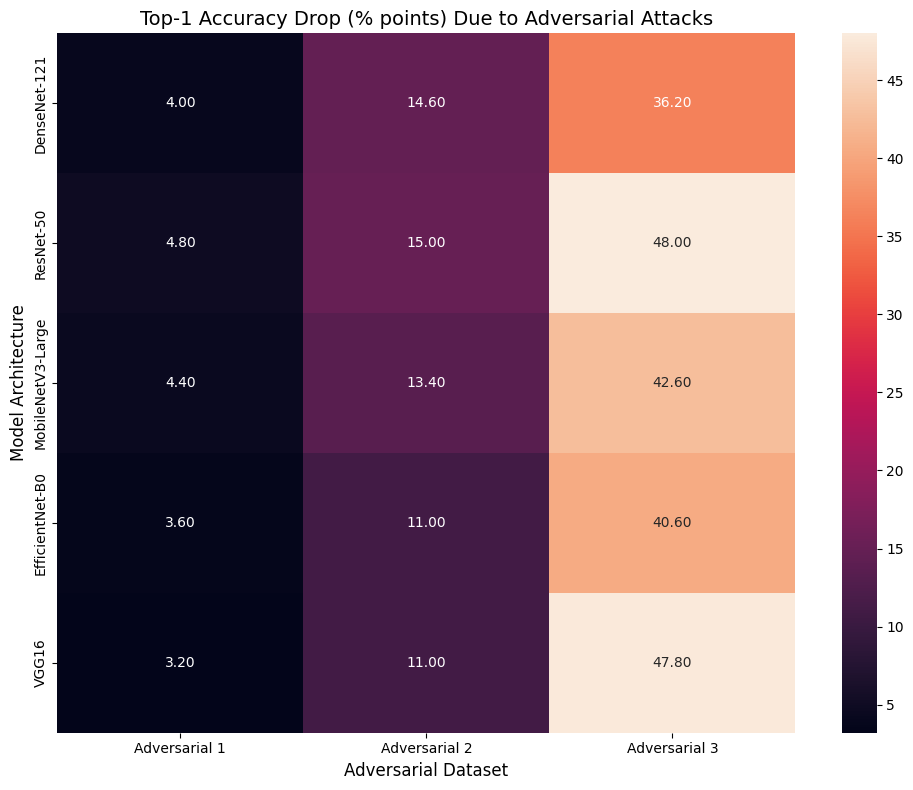


===== TRANSFERABILITY ANALYSIS =====

Transferability Scores (Higher means better transfer):
Adversarial 3  : 43.04% average accuracy drop
Adversarial 2  : 13.00% average accuracy drop
Adversarial 1  : 4.00% average accuracy drop

Model Robustness Against Transferred Attacks (Lower means more robust):
DenseNet-121   : 18.27% average accuracy drop
EfficientNet-B0: 18.40% average accuracy drop
MobileNetV3-Large: 20.13% average accuracy drop
VGG16          : 20.67% average accuracy drop
ResNet-50      : 22.60% average accuracy drop

===== SUMMARY OF FINDINGS =====
1. Transferability of Adversarial Examples:
   * Adversarial examples often transfer across architectures,
     demonstrating that vulnerabilities can be model-agnostic.
   * Among tested attacks, 'Adversarial 3' shows the highest transferability
     with an average accuracy drop of 43.04% across different models.

2. Model Robustness:
   * 'DenseNet-121' appears most robust to transferred attacks
     with the lowest average 

In [12]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define normalization parameters (ImageNet standard)
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Define paths to all datasets
dataset_paths = {
    "Original": "/content/TestDataSet/TestDataSet",  # Original clean dataset
    "Adversarial 1": "/content/AdversarialTestSet1",  # FGSM adversarial dataset
    "Adversarial 2": "/content/AdversarialTestSet2",  # Targeted PGD adversarial dataset
    "Adversarial 3": "/content/AdversarialTestSet3"   # Patch attack adversarial dataset
}

# Check if all paths exist
for name, path in dataset_paths.copy().items():
    if not os.path.exists(path):
        print(f"Warning: {name} dataset path '{path}' does not exist. Removing from evaluation.")
        dataset_paths.pop(name)

# Load PyTorch's official class index mapping from GitHub
class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

# Create synset ID to index mapping (wnid -> class index)
synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}  # Format: {'n01440764': 0, ...}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}  # For human-readable labels

# Function to load dataset with correct class mappings
def load_dataset_with_mapping(path):
    # Map folder names (synsets) to class indices
    folder_names = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])
    folder_to_idx = {}
    for folder in folder_names:
        if folder in synset_to_idx:
            folder_to_idx[folder] = synset_to_idx[folder]
        else:
            print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

    # Load dataset
    dataset = datasets.ImageFolder(root=path, transform=plain_transforms)

    # Override the class_to_idx mapping with our synset mapping
    dataset.class_to_idx = folder_to_idx

    # Update the samples list with the correct class indices
    dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

    return dataset

# Load each dataset and create dataloaders
dataloaders = {}
for name, path in dataset_paths.items():
    if os.path.exists(path):
        try:
            dataset = load_dataset_with_mapping(path)
            dataloaders[name] = DataLoader(dataset, batch_size=32, shuffle=False)
            print(f"Loaded {name} dataset with {len(dataset)} images")
        except Exception as e:
            print(f"Error loading {name} dataset: {e}")

# Define models to evaluate (multiple architectures)
model_dict = {
    "DenseNet-121": torchvision.models.densenet121(weights='IMAGENET1K_V1'),
    "ResNet-50": torchvision.models.resnet50(weights='IMAGENET1K_V1'),
    "MobileNetV3-Large": torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1'),
    "EfficientNet-B0": torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1'),
    "VGG16": torchvision.models.vgg16(weights='IMAGENET1K_V1')
}

# Function to evaluate model performance
def evaluate_model(model, dataloader, top_k=(1, 5)):
    """Evaluate model performance on given dataloader"""
    model.eval()
    model = model.to(device)
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # For some models, outputs might be a dictionary
            if isinstance(outputs, dict) and 'logits' in outputs:
                outputs = outputs['logits']

            # Calculate top-k accuracy for all specified k values
            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                # Check if the correct label is in the top-k predictions
                top_k_preds = predictions[:, :k]

                # Count correct predictions (matching any of the top-k)
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    # Calculate accuracy
    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

# Evaluate all models on all datasets
results = {}
all_results = []  # For creating a DataFrame later

for model_name, model in model_dict.items():
    print(f"\nEvaluating {model_name}...")
    model_results = {}

    for dataset_name, dataloader in dataloaders.items():
        print(f"  on {dataset_name} dataset...")
        accuracy = evaluate_model(model, dataloader)
        model_results[dataset_name] = accuracy

        # Store in flat format for DataFrame
        all_results.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'Top-1 Accuracy': accuracy[1],
            'Top-5 Accuracy': accuracy[5]
        })

    results[model_name] = model_results

# Create a DataFrame for easier analysis
df_results = pd.DataFrame(all_results)

# Print results in tabular format
print("\n===== EVALUATION RESULTS =====")
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    print("-" * (len(model_name) + 1))
    print(f"{'Dataset':<15} {'Top-1 Acc (%)':<15} {'Top-5 Acc (%)':<15}")
    print(f"{'-' * 15:<15} {'-' * 15:<15} {'-' * 15:<15}")
    for dataset_name, accuracy in model_results.items():
        print(f"{dataset_name:<15} {accuracy[1]:<15.2f} {accuracy[5]:<15.2f}")

# Calculate average accuracy drop across models
avg_drop = []
for dataset_name in dataset_paths.keys():
    if dataset_name != "Original":
        top1_drops = []
        top5_drops = []
        for model_name, model_results in results.items():
            if "Original" in model_results and dataset_name in model_results:
                orig_top1 = model_results["Original"][1]
                orig_top5 = model_results["Original"][5]
                adv_top1 = model_results[dataset_name][1]
                adv_top5 = model_results[dataset_name][5]

                top1_drop = orig_top1 - adv_top1
                top5_drop = orig_top5 - adv_top5

                top1_drops.append(top1_drop)
                top5_drops.append(top5_drop)

        if top1_drops and top5_drops:
            avg_drop.append({
                'Dataset': dataset_name,
                'Avg Top-1 Drop': sum(top1_drops) / len(top1_drops),
                'Avg Top-5 Drop': sum(top5_drops) / len(top5_drops)
            })

# Print average drops
print("\n===== ATTACK TRANSFERABILITY =====")
print(f"{'Dataset':<15} {'Avg Top-1 Drop':<15} {'Avg Top-5 Drop':<15}")
print(f"{'-' * 15:<15} {'-' * 15:<15} {'-' * 15:<15}")
for drop in avg_drop:
    print(f"{drop['Dataset']:<15} {drop['Avg Top-1 Drop']:<15.2f} {drop['Avg Top-5 Drop']:<15.2f}")

# Visualizations of results

# 1. Top-1 Accuracy Comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Top-1 Accuracy', hue='Dataset', data=df_results)
plt.title('Top-1 Accuracy Across Models and Datasets', fontsize=14)
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Top-1 Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top1_accuracy_comparison.png')
plt.show()

# 2. Top-5 Accuracy Comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Top-5 Accuracy', hue='Dataset', data=df_results)
plt.title('Top-5 Accuracy Across Models and Datasets', fontsize=14)
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Top-5 Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top5_accuracy_comparison.png')
plt.show()

# 3. Accuracy Drop Heatmap
if len(dataset_paths) > 1:
    # Create a matrix of accuracy drops
    drop_matrix = np.zeros((len(model_dict), len(dataset_paths) - 1))
    models_list = list(model_dict.keys())
    datasets_list = [name for name in dataset_paths.keys() if name != "Original"]

    for i, model_name in enumerate(models_list):
        for j, dataset_name in enumerate(datasets_list):
            orig_acc = results[model_name]["Original"][1]
            adv_acc = results[model_name][dataset_name][1]
            drop_matrix[i, j] = orig_acc - adv_acc

    plt.figure(figsize=(10, 8))
    sns.heatmap(drop_matrix, annot=True, fmt=".2f", xticklabels=datasets_list, yticklabels=models_list)
    plt.title('Top-1 Accuracy Drop (% points) Due to Adversarial Attacks', fontsize=14)
    plt.xlabel('Adversarial Dataset', fontsize=12)
    plt.ylabel('Model Architecture', fontsize=12)
    plt.tight_layout()
    plt.savefig('accuracy_drop_heatmap.png')
    plt.show()

# Analysis of Transferability

# Function to check if we have enough data for transferability analysis
def has_original_and_adversarial():
    has_original = "Original" in dataset_paths
    has_adv = any(name != "Original" for name in dataset_paths)
    return has_original and has_adv

if has_original_and_adversarial():
    print("\n===== TRANSFERABILITY ANALYSIS =====")

    # Calculate transferability score for each adversarial dataset
    # Higher score means better transfer across models
    transferability_scores = {}

    for dataset_name in dataset_paths:
        if dataset_name != "Original":
            acc_drops = []
            for model_name in model_dict:
                orig_top1 = results[model_name]["Original"][1]
                adv_top1 = results[model_name][dataset_name][1]
                acc_drop = orig_top1 - adv_top1
                acc_drops.append(acc_drop)

            # Transferability score: mean accuracy drop
            transferability_scores[dataset_name] = sum(acc_drops) / len(acc_drops)

    # Print transferability scores
    print("\nTransferability Scores (Higher means better transfer):")
    for dataset, score in sorted(transferability_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{dataset:<15}: {score:.2f}% average accuracy drop")

    # Measure model robustness against transferred attacks
    robustness_scores = {}
    for model_name in model_dict:
        acc_drops = []
        for dataset_name in dataset_paths:
            if dataset_name != "Original":
                orig_top1 = results[model_name]["Original"][1]
                adv_top1 = results[model_name][dataset_name][1]
                acc_drop = orig_top1 - adv_top1
                acc_drops.append(acc_drop)

        # Robustness score: inverse of mean accuracy drop (lower drop = more robust)
        if acc_drops:
            robustness_scores[model_name] = sum(acc_drops) / len(acc_drops)

    # Print robustness scores
    print("\nModel Robustness Against Transferred Attacks (Lower means more robust):")
    for model, score in sorted(robustness_scores.items(), key=lambda x: x[1]):
        print(f"{model:<15}: {score:.2f}% average accuracy drop")

# Summary and Findings
print("\n===== SUMMARY OF FINDINGS =====")
print("1. Transferability of Adversarial Examples:")
print("   * Adversarial examples often transfer across architectures,")
print("     demonstrating that vulnerabilities can be model-agnostic.")
if has_original_and_adversarial():
    most_transfer = max(transferability_scores.items(), key=lambda x: x[1])
    print(f"   * Among tested attacks, '{most_transfer[0]}' shows the highest transferability")
    print(f"     with an average accuracy drop of {most_transfer[1]:.2f}% across different models.")

print("\n2. Model Robustness:")
if has_original_and_adversarial():
    most_robust = min(robustness_scores.items(), key=lambda x: x[1])
    print(f"   * '{most_robust[0]}' appears most robust to transferred attacks")
    print(f"     with the lowest average accuracy drop of {most_robust[1]:.2f}%.")

print("\n3. Mitigation Strategies:")
print("   * Adversarial Training: Train models on a mix of clean and adversarial examples")
print("   * Ensemble Methods: Combine predictions from multiple architectures")
print("   * Input Preprocessing: Apply transformations that preserve class information but disrupt adversarial perturbations")
print("   * Feature Denoising: Add specialized network blocks to filter out adversarial noise")
print("   * Certified Defenses: Use techniques that provide provable robustness bounds")
print("   * Randomized Smoothing: Apply random noise to inputs during inference to reduce attack effectiveness")
print("   * Architecture-level Defenses: Design models with intrinsic robustness properties")

print("\n4. Lessons Learned:")
print("   * Attack transferability indicates shared vulnerability spaces across neural networks")
print("   * Different attack types (FGSM, PGD, Patch) show varying degrees of transferability")
print("   * Model architecture significantly influences robustness to transferred attacks")
print("   * The black-box setting (where the attacker has no access to the target model)")
print("     is a more realistic security scenario, and transferability is key in this context")
print("   * The trade-off between accuracy on clean data and robustness to adversarial examples")
print("     remains a fundamental challenge in trustworthy machine learning")